In [20]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier, ShapeDTW #Shapetest
#from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt


In [21]:
dataset = "Phoneme"
f = np.loadtxt(f"Smoothed/{dataset}_smoothed.csv", delimiter=",")
np.random.seed(0)
#np.random.shuffle(f)
ts = f[:, 2:]
labels = f[:, 0].astype(int)
train = f[:, 1].astype(bool)

In [33]:
def walker(ts, m, u= 0.1, g = 1): #only kinetic friction
    X = np.zeros_like(ts)
    col = ts.shape[0]
    N = ts.shape[1]
        
    for i in range(0,col):
        w = X[i, :]
        y = ts[i, :]
        
        w[0] = y[0]
        w[1] = y[1]
        #w[1] = w[0] + (y[1] - u_static * m * g) / m
        for k in range(2, N):
            #if w[k] - w[k-1] == 0:
                #if y[k] <= u_static * m * g:
                    #w[k] = w[k-1]
                    
            #w_inert = w[k-1] * 2 - w[k-2]
            w[k] = w[k-1] + (y[k] - u * m * g)/m
        
        X[i, :] = w
    
    return X

In [22]:
def walker(ts, m):
    X = np.zeros_like(ts)
    col = ts.shape[0]
    N = ts.shape[1]
    
    for i in range(0,col):
        w = X[i, :]
        y = ts[i, :]
        
        w[0] = y[0]
        w[1] = y[1]
        for k in range(2, N):
            w_inert = w[k-1] * 2 - w[k-2]
            w[k] = w_inert + (y[k] - w_inert)/m
        
        X[i, :] = w
    
    return X

In [23]:
def testaccuracy(m, train_acc = False):
    X = walker(ts, m)
        
    #np.random.seed(0)
    
    X_train, X_test = X[train], X[~train]
    y_train, y_test = labels[train], labels[~train] #train_test_split(X, labels)
    classifier = KNeighborsTimeSeriesClassifier(distance="euclidean")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    correct = 0
    total = X_train.shape[0]
    if train_acc:
        
        
        i = 0
        while i < len(X_train):
            classifier = KNeighborsTimeSeriesClassifier(distance="euclidean")
            ind = np.ones(X_train.shape[0], int)
            ind[i] = 0
            test = X_train[i]
            
            ind = ind.astype(bool)
            
            classifier.fit(X_train[ind], y_train[ind])
            
            pred = classifier.predict(np.array([test]))
            
            if pred[0] == y_train[i]:
                correct += 1
            
            i += 1
    
    return accuracy_score(y_test, y_pred), correct/total

In [24]:
def trainaccuracy(m):
    X = walker(ts, m)
    
    np.random.seed(0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, labels)
    
    correct = 0
    total = X_train.shape[0]
    i = 0
    while i < len(X_train):
        classifier = KNeighborsTimeSeriesClassifier(distance="euclidean")
        ind = np.ones(X_train.shape[0], int)
        ind[i] = 0
        test = X_train[i]
        
        ind = ind.astype(bool)
        
        classifier.fit(X_train[ind], y_train[ind])
        
        pred = classifier.predict(np.array([test]))
        
        if pred[0] == y_train[i]:
            correct += 1
        
        i += 1
    
    return correct/total

In [25]:
masses = np.arange(0, 200, 10)
masses[0] = 1
accuracy = np.zeros((masses.shape[0], 2))

In [26]:
#check higher masses


i = 0
for m in masses:
    #result = []
    #for _ in range(0, 1):
        #result.append(testaccuracy(m, train_acc = True))
    
    #result = np.array(result)
    #result = np.mean(result, axis = 0)

    result = testaccuracy(m, True)
    print(result)

    accuracy[i, 0] = result[0]
    accuracy[i, 1] = result[1]
    i += 1
    

(0.10917721518987342, 0.09813084112149532)
(0.07647679324894514, 0.06542056074766354)
(0.08069620253164557, 0.06074766355140187)
(0.07172995780590717, 0.06542056074766354)
(0.0680379746835443, 0.06542056074766354)
(0.06434599156118144, 0.0794392523364486)
(0.07014767932489452, 0.07476635514018691)
(0.0669831223628692, 0.0514018691588785)
(0.07225738396624473, 0.07009345794392523)
(0.0770042194092827, 0.056074766355140186)
(0.07067510548523206, 0.0514018691588785)
(0.0669831223628692, 0.037383177570093455)
(0.06645569620253164, 0.04672897196261682)
(0.0669831223628692, 0.0514018691588785)
(0.06487341772151899, 0.056074766355140186)
(0.06434599156118144, 0.056074766355140186)
(0.06434599156118144, 0.056074766355140186)
(0.06909282700421941, 0.0514018691588785)
(0.06540084388185655, 0.028037383177570093)
(0.06592827004219409, 0.04205607476635514)


Text(0.5, 1.0, 'Phoneme')

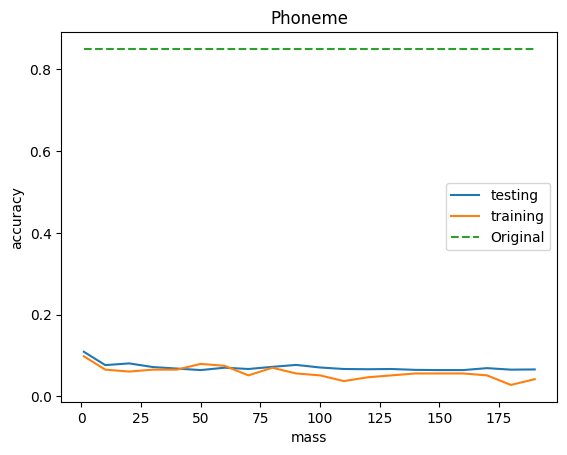

In [27]:
dash = [0.85] * masses.shape[0]
dash = np.array(dash)

plt.clf()
plt.plot(masses, accuracy[:, 0], "-", label="testing")

plt.plot(masses, accuracy[:, 1], "-", label="training")
plt.plot(masses, dash, "--", label="Original" )
plt.xlabel("mass")
plt.ylabel("accuracy")
plt.legend()
plt.title(dataset)

In [69]:
masses2 = np.arange(310, 451, 10)
accuracy2 = np.zeros((masses2.shape[0], 2))

i = 0
for m in masses2:
    #result = []
    #for _ in range(0, 1):
        #result.append(testaccuracy(m, train_acc = True))
    
    #result = np.array(result)
    #result = np.mean(result, axis = 0)

    result = testaccuracy(m, False)
    print(result)

    accuracy2[i, 0] = result[0]
    accuracy2[i, 1] = result[1]
    i += 1

(0.8862311801845556, 0.0)
(0.8881738708110734, 0.0)
(0.8830743079164644, 0.0)
(0.8829528897523069, 0.0)
(0.8813744536182613, 0.0)
(0.8804031083050025, 0.0)
(0.8824672170956775, 0.0)
(0.8827100534239922, 0.0)
(0.8834385624089364, 0.0)
(0.8848955803788247, 0.0)
(0.8867168528411851, 0.0)
(0.8873239436619719, 0.0)
(0.888052452646916, 0.0)
(0.8918164157357941, 0.0)
(0.8899951432734337, 0.0)


In [70]:
accuracy = np.append(accuracy, accuracy2, axis = 0)
masses = np.append(masses, masses2)

Text(0.5, 1.0, 'StarLightCurves')

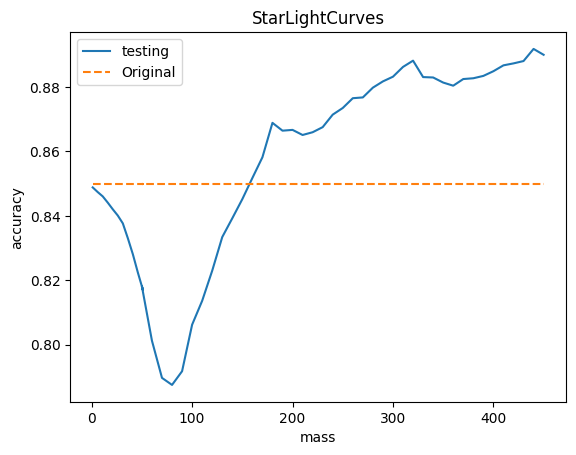

In [71]:
dash = [0.85] * masses.shape[0]
dash = np.array(dash)

plt.clf()
plt.plot(masses, accuracy[:, 0], "-", label="testing")

#plt.plot(masses2, accuracy2[:, 1], "-", label="training")
plt.plot(masses, dash, "--", label="Original" )
plt.xlabel("mass")
plt.ylabel("accuracy")
plt.legend()
plt.title(dataset)

In [79]:
data = np.zeros((masses.shape[0], 3))
data[:, 0] = masses
data[:, 1:] = accuracy

np.savetxt('Starlight_Accuracy.txt',data, delimiter=',', header="mass,test,train")